# Student Dropout Prediction Model
This notebook contains data preprocessing, feature engineering, and machine learning model training for predicting student dropout.


In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_excel(r'student dropout.xlsx')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

Dataset shape: (649, 34)

Columns: ['School', 'Gender', 'Age', 'Address', 'Family_Size', 'Parental_Status', 'Mother_Education', 'Father_Education', 'Mother_Job', 'Father_Job', 'Reason_for_Choosing_School', 'Guardian', 'Travel_Time', 'Study_Time', 'Number_of_Failures', 'School_Support', 'Family_Support', 'Extra_Paid_Class', 'Extra_Curricular_Activities', 'Attended_Nursery', 'Wants_Higher_Education', 'Internet_Access', 'In_Relationship', 'Family_Relationship', 'Free_Time', 'Going_Out', 'Weekend_Alcohol_Consumption', 'Weekday_Alcohol_Consumption', 'Health_Status', 'Number_of_Absences', 'Grade_1', 'Grade_2', 'Final_Grade', 'Dropped_Out']


In [7]:
print("Missing values:")
print(df.isnull().sum())
print("\nData types:")
print(df.dtypes)
print("\nTarget variable distribution:")
print(df['Dropped_Out'].value_counts())
print(df['Dropped_Out'].value_counts(normalize=True) * 100)

Missing values:
School                         0
Gender                         0
Age                            0
Address                        0
Family_Size                    0
Parental_Status                0
Mother_Education               0
Father_Education               0
Mother_Job                     0
Father_Job                     0
Reason_for_Choosing_School     0
Guardian                       0
Travel_Time                    0
Study_Time                     0
Number_of_Failures             0
School_Support                 0
Family_Support                 0
Extra_Paid_Class               0
Extra_Curricular_Activities    0
Attended_Nursery               0
Wants_Higher_Education         0
Internet_Access                0
In_Relationship                0
Family_Relationship            0
Free_Time                      0
Going_Out                      0
Weekend_Alcohol_Consumption    0
Weekday_Alcohol_Consumption    0
Health_Status                  0
Number_of_Absences         

In [8]:
# Separate features and target variable
X = df.drop('Dropped_Out', axis=1)
y = df['Dropped_Out']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

Categorical columns: ['School', 'Gender', 'Address', 'Family_Size', 'Parental_Status', 'Mother_Job', 'Father_Job', 'Reason_for_Choosing_School', 'Guardian', 'School_Support', 'Family_Support', 'Extra_Paid_Class', 'Extra_Curricular_Activities', 'Attended_Nursery', 'Wants_Higher_Education', 'Internet_Access', 'In_Relationship']
Numerical columns: ['Age', 'Mother_Education', 'Father_Education', 'Travel_Time', 'Study_Time', 'Number_of_Failures', 'Family_Relationship', 'Free_Time', 'Going_Out', 'Weekend_Alcohol_Consumption', 'Weekday_Alcohol_Consumption', 'Health_Status', 'Number_of_Absences', 'Grade_1', 'Grade_2', 'Final_Grade']


In [9]:
# Feature Engineering
X_processed = X.copy()

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_processed[col] = le.fit_transform(X_processed[col])
    label_encoders[col] = le

# Create new features
# Average grade
X_processed['Average_Grade'] = (X_processed['Grade_1'] + X_processed['Grade_2'] + X_processed['Final_Grade']) / 3

# Grade improvement
X_processed['Grade_Improvement'] = X_processed['Final_Grade'] - X_processed['Grade_1']

# Family education level (average of mother and father education)
# X_processed['Family_Education_Avg'] = (X_processed['Mother_Education'] + X_processed['Father_Education']) / 2

# Study to free time ratio
X_processed['Study_Free_Ratio'] = X_processed['Study_Time'] / (X_processed['Free_Time'] + 1)  

X_processed['Total_Alcohol'] = X_processed['Weekend_Alcohol_Consumption'] + X_processed['Weekday_Alcohol_Consumption']

print(f"New features created. Dataset shape: {X_processed.shape}")
print(f"New columns: {X_processed.columns[-5:].tolist()}")

New features created. Dataset shape: (649, 37)
New columns: ['Final_Grade', 'Average_Grade', 'Grade_Improvement', 'Study_Free_Ratio', 'Total_Alcohol']


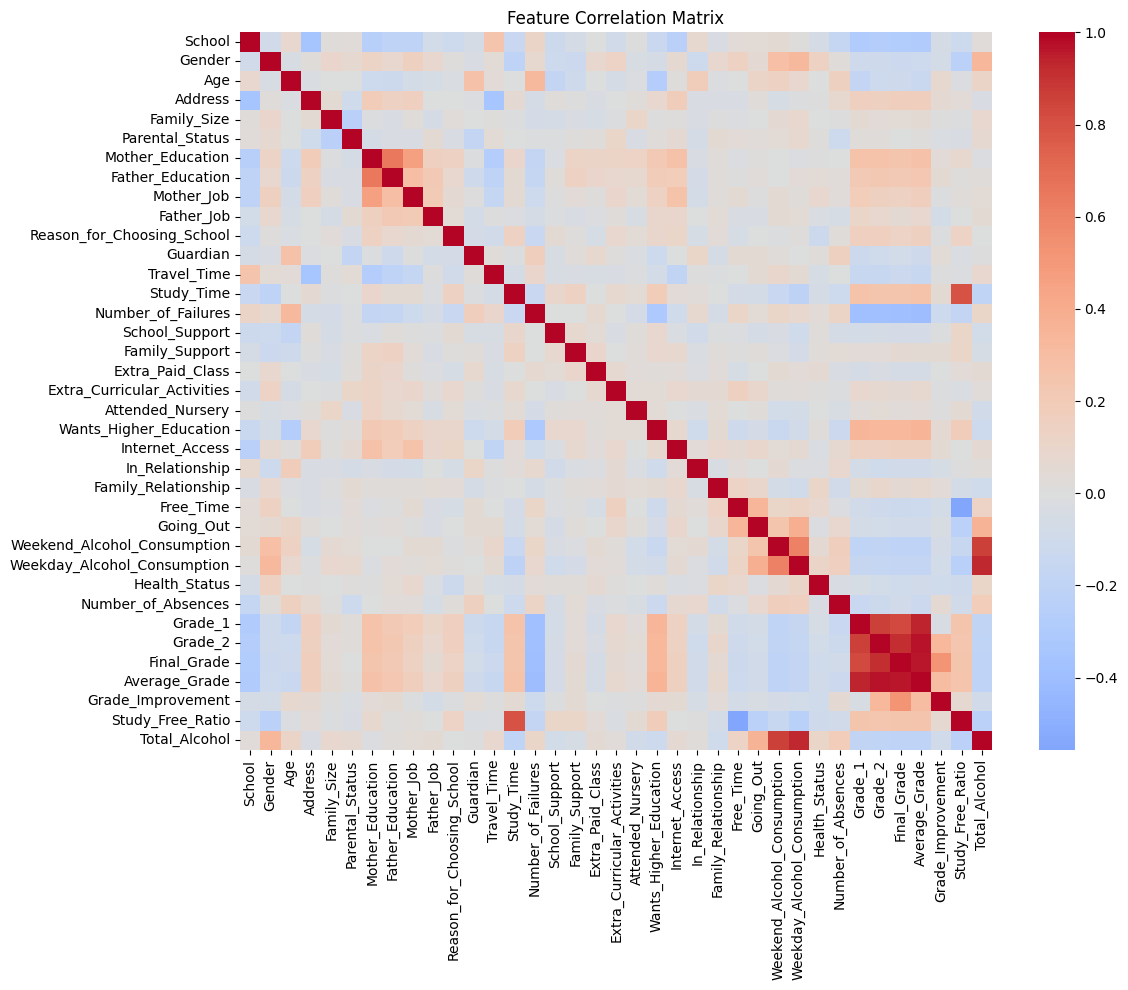


Correlation with target variable (Dropped_Out):
Dropped_Out                    1.000000
Number_of_Failures             0.380237
School                         0.297217
Total_Alcohol                  0.132323
Weekend_Alcohol_Consumption    0.123627
Weekday_Alcohol_Consumption    0.116249
Age                            0.110722
Free_Time                      0.093349
Number_of_Absences             0.087483
Guardian                       0.084384
In_Relationship                0.081177
Gender                         0.078222
Going_Out                      0.067241
Travel_Time                    0.057869
Extra_Paid_Class               0.053708
Health_Status                  0.009979
Attended_Nursery               0.007751
Parental_Status                0.004241
Father_Job                    -0.002454
School_Support                -0.034527
Family_Support                -0.037903
Family_Relationship           -0.044987
Extra_Curricular_Activities   -0.047276
Family_Size                   -

In [10]:
# Feature correlation analysis
plt.figure(figsize=(12, 10))
correlation_matrix = X_processed.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Show correlation with target variable
target_corr = pd.concat([X_processed, y], axis=1).corr()['Dropped_Out'].sort_values(ascending=False)
print("\nCorrelation with target variable (Dropped_Out):")
print(target_corr)

In [11]:

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training set target distribution: {y_train.value_counts()}")
print(f"Test set target distribution: {y_test.value_counts()}")

Training set shape: (519, 37)
Test set shape: (130, 37)
Training set target distribution: Dropped_Out
False    439
True      80
Name: count, dtype: int64
Test set target distribution: Dropped_Out
False    110
True      20
Name: count, dtype: int64


In [12]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
# Train Logistic Regression Model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calculate accuracy
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

# Classification report
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.9769

Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.99      0.99       110
        True       0.95      0.90      0.92        20

    accuracy                           0.98       130
   macro avg       0.96      0.95      0.95       130
weighted avg       0.98      0.98      0.98       130



In [14]:
# Train Random Forest Model for comparison
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9923

Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00       110
        True       1.00      0.95      0.97        20

    accuracy                           0.99       130
   macro avg       1.00      0.97      0.98       130
weighted avg       0.99      0.99      0.99       130



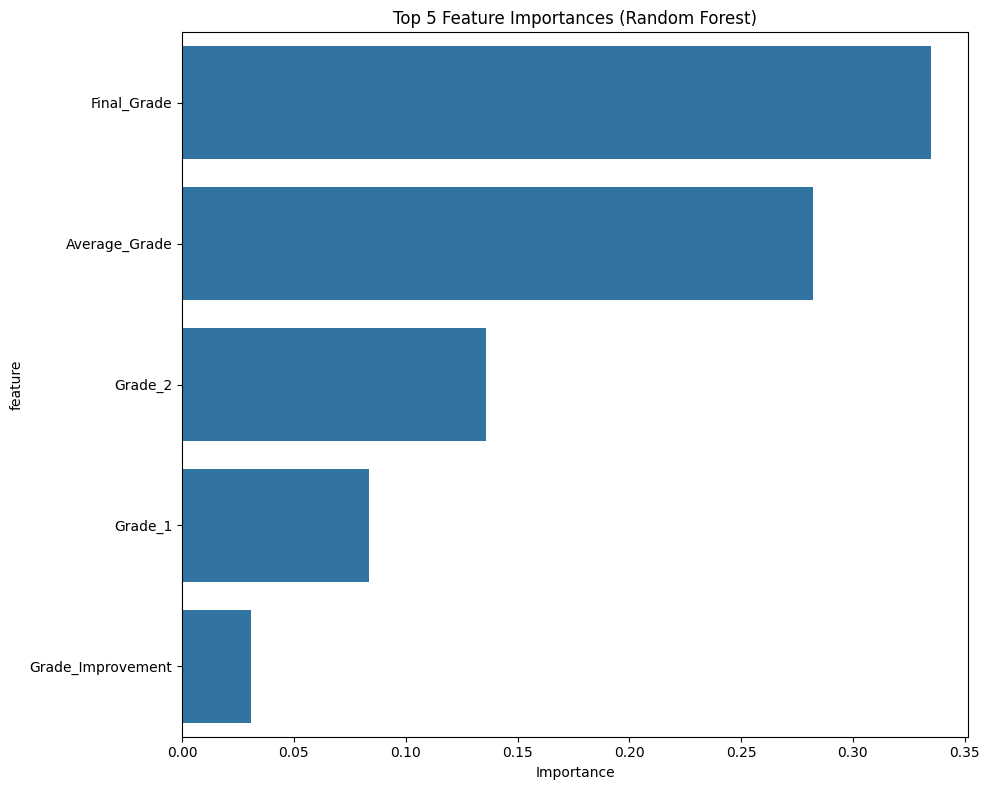

Top 10 Most Important Features:
                   feature  importance
32             Final_Grade    0.334748
33           Average_Grade    0.282358
31                 Grade_2    0.135993
30                 Grade_1    0.083520
34       Grade_Improvement    0.031012
14      Number_of_Failures    0.020667
20  Wants_Higher_Education    0.011759
0                   School    0.008036
35        Study_Free_Ratio    0.007678
36           Total_Alcohol    0.007109


In [15]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X_processed.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(5), x='importance', y='feature')
plt.title('Top 5 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

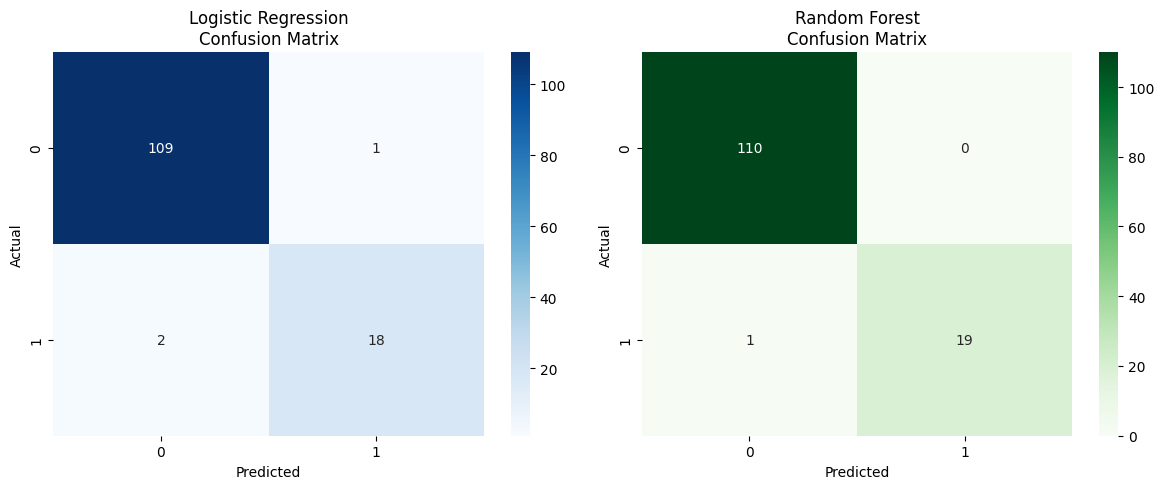

In [16]:
# Confusion Matrix Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Logistic Regression\nConfusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Random Forest\nConfusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [17]:
# Model Comparison Summary
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print("\nBest performing model:", "Random Forest" if rf_accuracy > lr_accuracy else "Logistic Regression")
print(f"Accuracy difference: {abs(rf_accuracy - lr_accuracy):.4f}")

Logistic Regression Accuracy: 0.9769
Random Forest Accuracy: 0.9923

Best performing model: Random Forest
Accuracy difference: 0.0154


In [18]:
# catboost model

from catboost import CatBoostClassifier
# from catboost_widget import CatBoostWidget

cat_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_seed=42, verbose=100)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4824227	test: 0.4906568	best: 0.4906568 (0)	total: 171ms	remaining: 16.9s
99:	learn: 0.0009896	test: 0.0013985	best: 0.0013985 (99)	total: 660ms	remaining: 0us

bestTest = 0.001398467845
bestIteration = 99



In [ ]:
# predictions
y_pred_cat = cat_model.predict(X_test)
y_pred_proba_cat = cat_model.predict_proba(X_test)[:, 1]

# test accuracy
cat_accuracy = accuracy_score(y_test, y_pred_cat)
print(f"CatBoost Accuracy: {cat_accuracy:.4f}")
print("\nCatBoost Classification Report:")
print(classification_report(y_test, y_pred_cat))


In [ ]:
# Feature importance from catboost
feature_importance_cat = pd.DataFrame({
    'feature': X_processed.columns,
    'importance': cat_model.feature_importances_
}).sort_values('importance', ascending=False)

# display feature importance
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_cat.head(10), x='importance', y='feature')
plt.title('Top 5 Feature Importances (CatBoost)')

In [ ]:
# confusion matrix visualization
cm_cat = confusion_matrix(y_test, y_pred_cat)
sns.heatmap(cm_cat, annot=True, fmt='d', cmap='Purples')
plt.title('CatBoost\nConfusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
# # Save the trained models and preprocessors
# import joblib

# # Save models
# joblib.dump(lr_model, 'logistic_regression_model.pkl')
# joblib.dump(rf_model, 'random_forest_model.pkl')
# joblib.dump(scaler, 'feature_scaler.pkl')
# joblib.dump(label_encoders, 'label_encoders.pkl')
# joblib.dump(cat_model, 'catboost_model.pkl')

# print("Models and preprocessors saved successfully!")
# print("Files saved:")
# print("- logistic_regression_model.pkl")
# print("- random_forest_model.pkl")
# print("- feature_scaler.pkl")
# print("- label_encoders.pkl")
# print("- catboost_model.pkl")